In [2]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import random
import numpy as np
import timeit
from tqdm import tqdm
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/AnimeDataSet.zip" -d "/content/Anime_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/Anime_dataset/images/62764_2019.jpg  
  inflating: /content/Anime_dataset/images/62765_2019.jpg  
  inflating: /content/Anime_dataset/images/62766_2019.jpg  
  inflating: /content/Anime_dataset/images/62767_2019.jpg  
  inflating: /content/Anime_dataset/images/62768_2019.jpg  
  inflating: /content/Anime_dataset/images/62769_2019.jpg  
  inflating: /content/Anime_dataset/images/6276_2003.jpg  
  inflating: /content/Anime_dataset/images/62770_2019.jpg  
  inflating: /content/Anime_dataset/images/62771_2019.jpg  
  inflating: /content/Anime_dataset/images/62772_2019.jpg  
  inflating: /content/Anime_dataset/images/62773_2019.jpg  
  inflating: /content/Anime_dataset/images/62774_2019.jpg  
  inflating: /content/Anime_dataset/images/62775_2019.jpg  
  inflating: /content/Anime_dataset/images/62776_2019.jpg  
  inflating: /content/Anime_dataset/images/62777_2019.jpg  
  inflating: /content/Anime_dataset/images/62778_2

In [5]:
DATA_DIR = "/content/Anime_dataset"
BATCH_SIZE = 128
IMG_SIZE = 64
CHANNELS = 3
INPUT_VECTOR_DIM = 100
FEATURE_MAP_DIM = 32
LR = 2e-4
disc_LR = 5e-5
BETA1 = 0.5
EPOCHS = 150
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_dim, channels):
        super(Discriminator, self).__init__()
        self.conv_1 = nn.Conv2d(channels, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.conv_2 = nn.Conv2d(feature_map_dim*2, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.conv_3 = nn.Conv2d(feature_map_dim*4, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.conv_4 = nn.Conv2d(feature_map_dim*8, feature_map_dim*16, 4, 2, 1, bias=False) #size [1024, 4, 4]
        self.conv_5 = nn.Conv2d(feature_map_dim*16, 1, 4, 1, 0, bias=False) #size [1, 1, 1]

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*16)

        self.sigmoid = nn.Sigmoid()


    def forward(self, inp):
        x = self.conv_1(inp)
        x = self.leaky_relu(x)

        x = self.conv_2(x)
        x = self.batch_norm_1(x)
        x = self.leaky_relu(x)

        x = self.conv_3(x)
        x = self.batch_norm_2(x)
        x = self.leaky_relu(x)

        x = self.conv_4(x)
        x = self.batch_norm_3(x)
        x = self.leaky_relu(x)

        x = self.conv_5(x)
        out = self.sigmoid(x)

        return out

In [7]:
discriminator = Discriminator(FEATURE_MAP_DIM, CHANNELS).to(device)

x = torch.randn(BATCH_SIZE, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)
dis_out = discriminator(x)
print(dis_out.size())

torch.Size([128, 1, 1, 1])


In [8]:
class Generator(nn.Module):
    def __init__(self, input_vector_dim, feature_map_dim, channels):
        super(Generator, self).__init__()
        self.convt_1 = nn.ConvTranspose2d(input_vector_dim, feature_map_dim*16, 4, 1, 0, bias=False) #size [1024, 4, 4]
        self.convt_2 = nn.ConvTranspose2d(feature_map_dim*16, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.convt_3 = nn.ConvTranspose2d(feature_map_dim*8, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.convt_4 = nn.ConvTranspose2d(feature_map_dim*4, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.convt_5 = nn.ConvTranspose2d(feature_map_dim*2, channels, 4, 2, 1, bias=False) #size [3, 64, 64]

        self.relu = nn.ReLU()

        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)

        self.tanh = nn.Tanh()

    def forward(self, inp):
        x = self.convt_1(inp)
        x = self.batch_norm_1(x)
        x = self.relu(x)

        x = self.convt_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)

        x = self.convt_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)

        x = self.convt_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)

        x = self.convt_5(x)
        out = self.tanh(x)

        return out

In [9]:
generator = Generator(INPUT_VECTOR_DIM, FEATURE_MAP_DIM, CHANNELS).to(device)

noise = torch.randn(BATCH_SIZE, INPUT_VECTOR_DIM, 1, 1, device=device)
gen_out = generator(noise)
print(gen_out.size())

torch.Size([128, 3, 64, 64])


In [10]:
dataset = ImageFolder(DATA_DIR,
                           transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize(*((0.5,0.5,0.5),(0.5,0.5,0.5))),
                           ]))


dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

In [11]:
checkpoint_path = "/content/drive/My Drive/DCGAN_Checkpoint.pth"

# Load Checkpoint Function
def load_checkpoint(generator, discriminator, gen_opt, disc_opt):
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        gen_opt.load_state_dict(checkpoint['gen_optimizer_state_dict'])
        disc_opt.load_state_dict(checkpoint['disc_optimizer_state_dict'])
        print(f"Checkpoint loaded from epoch {checkpoint['epoch']+1}")
        return checkpoint['epoch'] + 1  # Resume from next epoch
    return 0  # Start from scratch

In [12]:
# Save Checkpoint Function
def save_checkpoint(epoch, generator, discriminator, gen_opt, disc_opt):
    checkpoint = {
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'gen_optimizer_state_dict': gen_opt.state_dict(),
        'disc_optimizer_state_dict': disc_opt.state_dict()
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

Checkpoint loaded from epoch 120


100%|██████████| 497/497 [01:53<00:00,  4.40it/s]


Discriminator Loss EPOCH 121: 0.0202
Generator Loss EPOCH 121: 5.5337
Models saved: generator_epoch_121.pth, discriminator_epoch_121.pth
Checkpoint saved at epoch 121


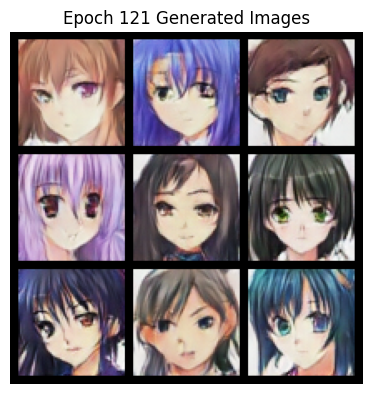

100%|██████████| 497/497 [01:52<00:00,  4.41it/s]


Discriminator Loss EPOCH 122: 0.0822
Generator Loss EPOCH 122: 5.3294
Models saved: generator_epoch_122.pth, discriminator_epoch_122.pth
Checkpoint saved at epoch 122


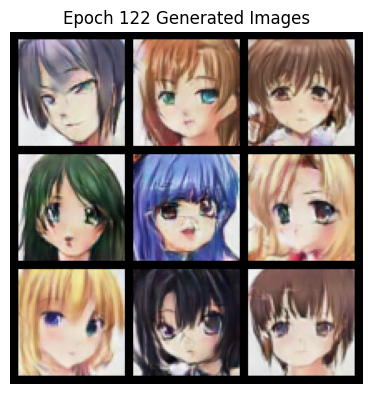

100%|██████████| 497/497 [01:53<00:00,  4.37it/s]


Discriminator Loss EPOCH 123: 0.0347
Generator Loss EPOCH 123: 5.3986
Models saved: generator_epoch_123.pth, discriminator_epoch_123.pth
Checkpoint saved at epoch 123


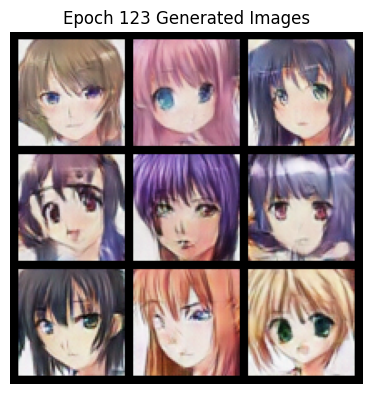

100%|██████████| 497/497 [01:54<00:00,  4.34it/s]


Discriminator Loss EPOCH 124: 0.0395
Generator Loss EPOCH 124: 5.5794
Models saved: generator_epoch_124.pth, discriminator_epoch_124.pth
Checkpoint saved at epoch 124


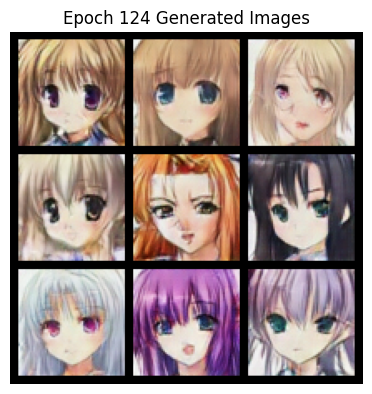

100%|██████████| 497/497 [01:54<00:00,  4.33it/s]


Discriminator Loss EPOCH 125: 0.0685
Generator Loss EPOCH 125: 5.0073
Models saved: generator_epoch_125.pth, discriminator_epoch_125.pth
Checkpoint saved at epoch 125


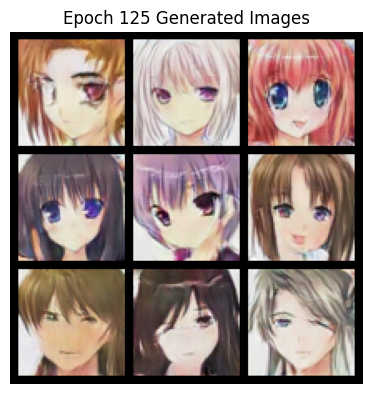

100%|██████████| 497/497 [01:54<00:00,  4.35it/s]


Discriminator Loss EPOCH 126: 0.0191
Generator Loss EPOCH 126: 5.5989
Models saved: generator_epoch_126.pth, discriminator_epoch_126.pth
Checkpoint saved at epoch 126


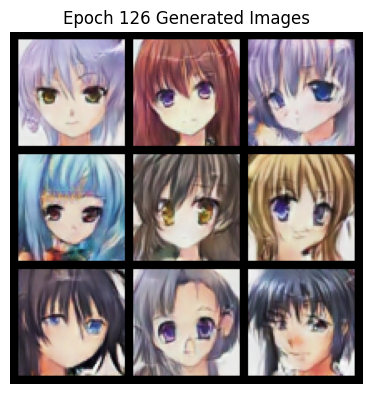

100%|██████████| 497/497 [01:54<00:00,  4.33it/s]


Discriminator Loss EPOCH 127: 0.0626
Generator Loss EPOCH 127: 5.4570
Models saved: generator_epoch_127.pth, discriminator_epoch_127.pth
Checkpoint saved at epoch 127


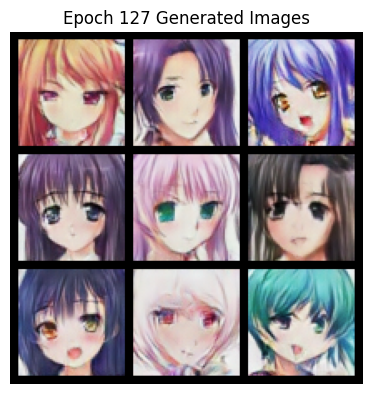

100%|██████████| 497/497 [01:55<00:00,  4.31it/s]


Discriminator Loss EPOCH 128: 0.0383
Generator Loss EPOCH 128: 5.6475
Models saved: generator_epoch_128.pth, discriminator_epoch_128.pth
Checkpoint saved at epoch 128


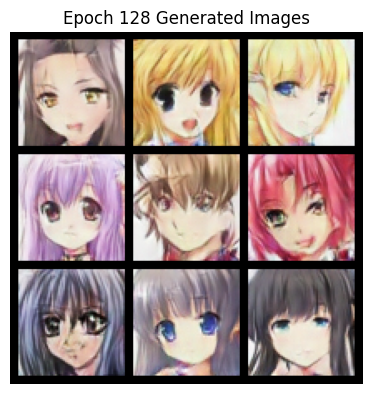

100%|██████████| 497/497 [01:55<00:00,  4.31it/s]


Discriminator Loss EPOCH 129: 0.0781
Generator Loss EPOCH 129: 4.9865
Models saved: generator_epoch_129.pth, discriminator_epoch_129.pth
Checkpoint saved at epoch 129


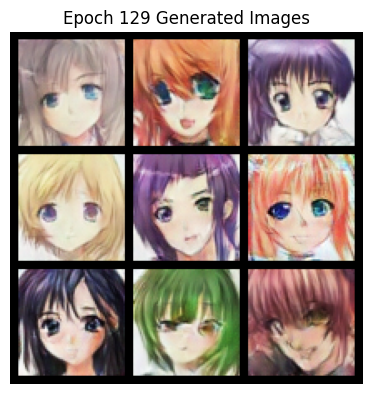

100%|██████████| 497/497 [01:56<00:00,  4.28it/s]


Discriminator Loss EPOCH 130: 0.0469
Generator Loss EPOCH 130: 5.0537
Models saved: generator_epoch_130.pth, discriminator_epoch_130.pth
Checkpoint saved at epoch 130


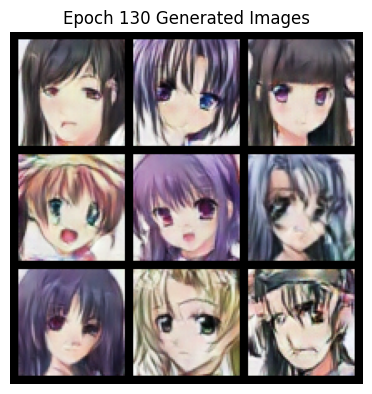

100%|██████████| 497/497 [01:56<00:00,  4.26it/s]


Discriminator Loss EPOCH 131: 0.0127
Generator Loss EPOCH 131: 5.8434
Models saved: generator_epoch_131.pth, discriminator_epoch_131.pth
Checkpoint saved at epoch 131


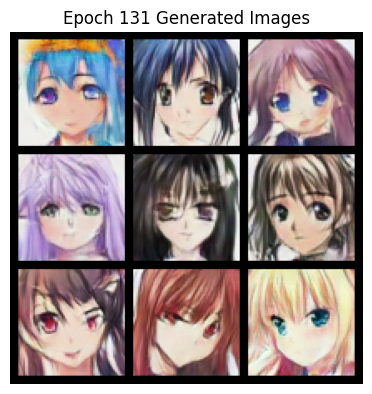

100%|██████████| 497/497 [01:57<00:00,  4.23it/s]


Discriminator Loss EPOCH 132: 0.0447
Generator Loss EPOCH 132: 6.1090
Models saved: generator_epoch_132.pth, discriminator_epoch_132.pth
Checkpoint saved at epoch 132


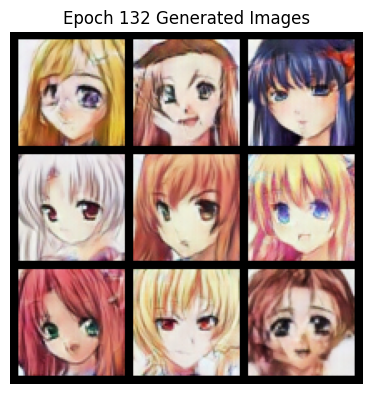

100%|██████████| 497/497 [01:57<00:00,  4.22it/s]


Discriminator Loss EPOCH 133: 0.0974
Generator Loss EPOCH 133: 4.6971
Models saved: generator_epoch_133.pth, discriminator_epoch_133.pth
Checkpoint saved at epoch 133


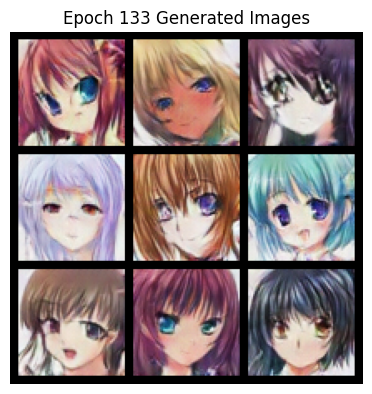

100%|██████████| 497/497 [01:58<00:00,  4.20it/s]


Discriminator Loss EPOCH 134: 0.0161
Generator Loss EPOCH 134: 5.6618
Models saved: generator_epoch_134.pth, discriminator_epoch_134.pth
Checkpoint saved at epoch 134


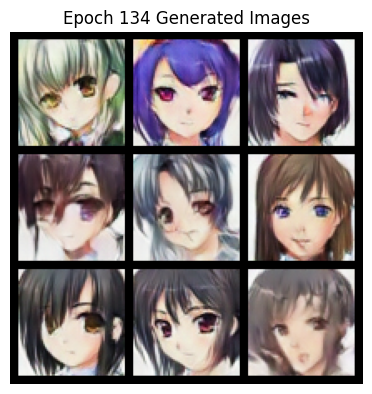

100%|██████████| 497/497 [01:58<00:00,  4.20it/s]


Discriminator Loss EPOCH 135: 0.0111
Generator Loss EPOCH 135: 6.0416
Models saved: generator_epoch_135.pth, discriminator_epoch_135.pth
Checkpoint saved at epoch 135


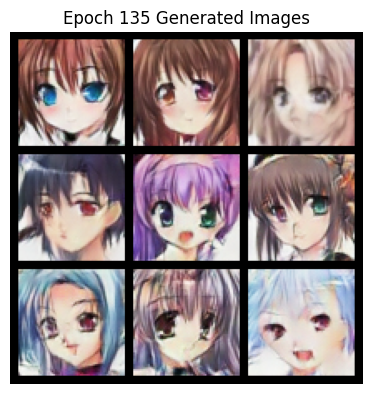

100%|██████████| 497/497 [01:59<00:00,  4.17it/s]


Discriminator Loss EPOCH 136: 0.0821
Generator Loss EPOCH 136: 5.3500
Models saved: generator_epoch_136.pth, discriminator_epoch_136.pth
Checkpoint saved at epoch 136


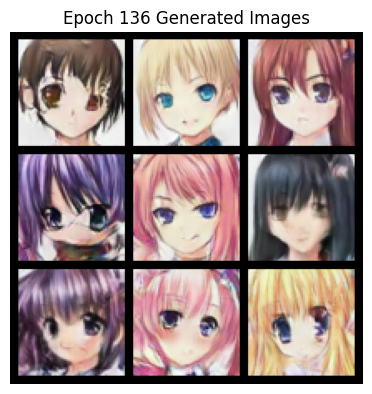

100%|██████████| 497/497 [01:59<00:00,  4.16it/s]


Discriminator Loss EPOCH 137: 0.0419
Generator Loss EPOCH 137: 5.6142
Models saved: generator_epoch_137.pth, discriminator_epoch_137.pth
Checkpoint saved at epoch 137


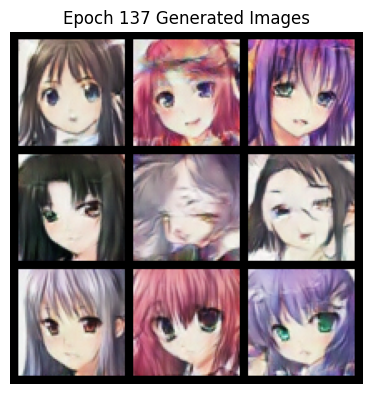

100%|██████████| 497/497 [02:00<00:00,  4.13it/s]


Discriminator Loss EPOCH 138: 0.0434
Generator Loss EPOCH 138: 5.7093
Models saved: generator_epoch_138.pth, discriminator_epoch_138.pth
Checkpoint saved at epoch 138


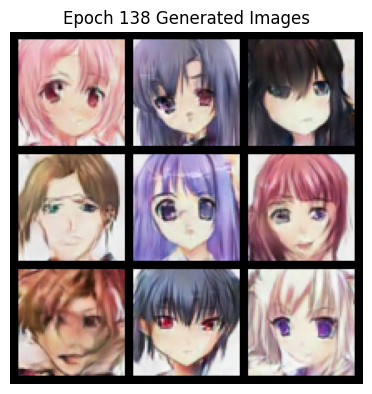

100%|██████████| 497/497 [02:02<00:00,  4.04it/s]


Discriminator Loss EPOCH 139: 0.0117
Generator Loss EPOCH 139: 6.0719
Models saved: generator_epoch_139.pth, discriminator_epoch_139.pth
Checkpoint saved at epoch 139


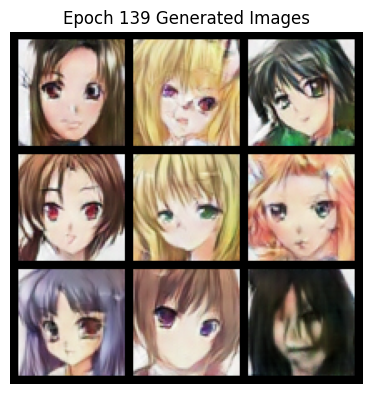

100%|██████████| 497/497 [02:01<00:00,  4.09it/s]


Discriminator Loss EPOCH 140: 0.0694
Generator Loss EPOCH 140: 5.8079
Models saved: generator_epoch_140.pth, discriminator_epoch_140.pth
Checkpoint saved at epoch 140


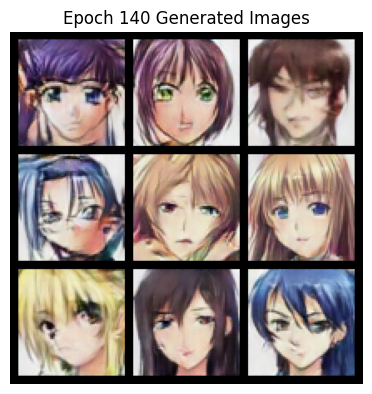

100%|██████████| 497/497 [02:01<00:00,  4.08it/s]


Discriminator Loss EPOCH 141: 0.0552
Generator Loss EPOCH 141: 5.2261
Models saved: generator_epoch_141.pth, discriminator_epoch_141.pth
Checkpoint saved at epoch 141


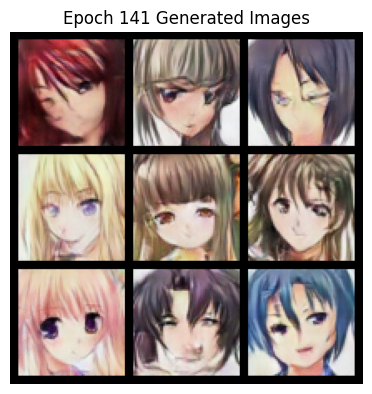

100%|██████████| 497/497 [02:02<00:00,  4.06it/s]


Discriminator Loss EPOCH 142: 0.0115
Generator Loss EPOCH 142: 6.0287
Models saved: generator_epoch_142.pth, discriminator_epoch_142.pth
Checkpoint saved at epoch 142


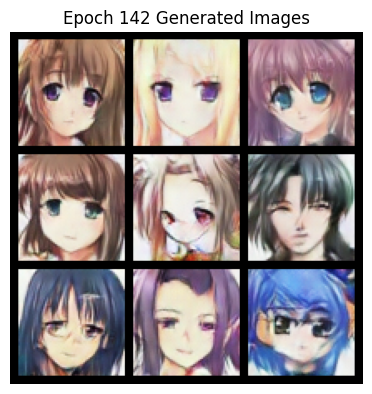

100%|██████████| 497/497 [02:03<00:00,  4.03it/s]


Discriminator Loss EPOCH 143: 0.0670
Generator Loss EPOCH 143: 5.5187
Models saved: generator_epoch_143.pth, discriminator_epoch_143.pth
Checkpoint saved at epoch 143


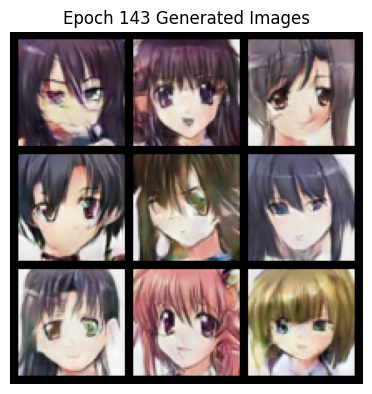

100%|██████████| 497/497 [02:03<00:00,  4.02it/s]


Discriminator Loss EPOCH 144: 0.0384
Generator Loss EPOCH 144: 5.8285
Models saved: generator_epoch_144.pth, discriminator_epoch_144.pth
Checkpoint saved at epoch 144


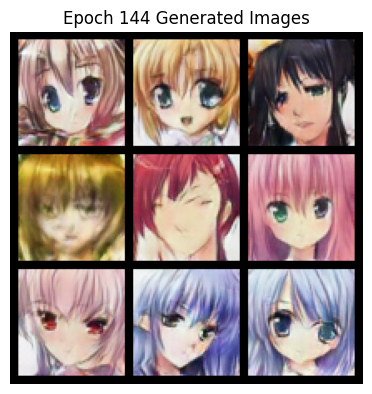

100%|██████████| 497/497 [02:03<00:00,  4.02it/s]


Discriminator Loss EPOCH 145: 0.0410
Generator Loss EPOCH 145: 5.6972
Models saved: generator_epoch_145.pth, discriminator_epoch_145.pth
Checkpoint saved at epoch 145


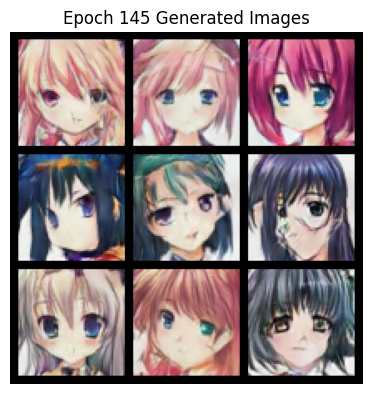

100%|██████████| 497/497 [02:04<00:00,  4.00it/s]


Discriminator Loss EPOCH 146: 0.0109
Generator Loss EPOCH 146: 6.1708
Models saved: generator_epoch_146.pth, discriminator_epoch_146.pth
Checkpoint saved at epoch 146


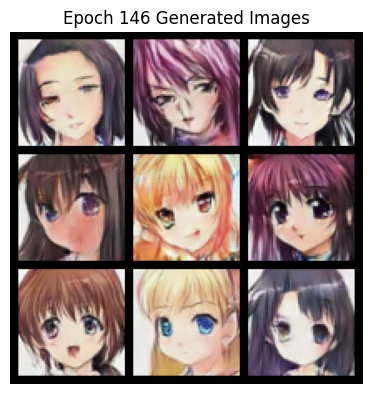

100%|██████████| 497/497 [02:04<00:00,  3.99it/s]


Discriminator Loss EPOCH 147: 0.0457
Generator Loss EPOCH 147: 5.8419
Models saved: generator_epoch_147.pth, discriminator_epoch_147.pth
Checkpoint saved at epoch 147


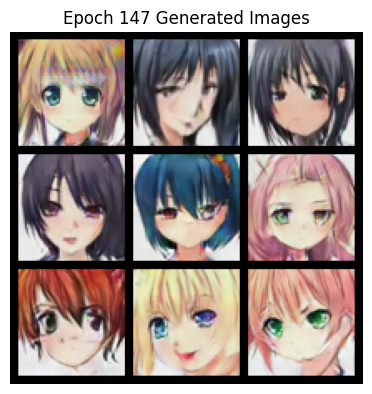

100%|██████████| 497/497 [02:05<00:00,  3.95it/s]


Discriminator Loss EPOCH 148: 0.0488
Generator Loss EPOCH 148: 5.8443
Models saved: generator_epoch_148.pth, discriminator_epoch_148.pth
Checkpoint saved at epoch 148


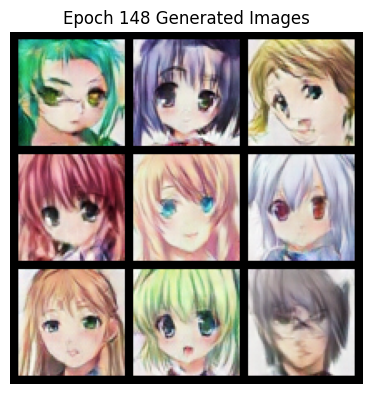

100%|██████████| 497/497 [02:05<00:00,  3.97it/s]


Discriminator Loss EPOCH 149: 0.0117
Generator Loss EPOCH 149: 6.1127
Models saved: generator_epoch_149.pth, discriminator_epoch_149.pth
Checkpoint saved at epoch 149


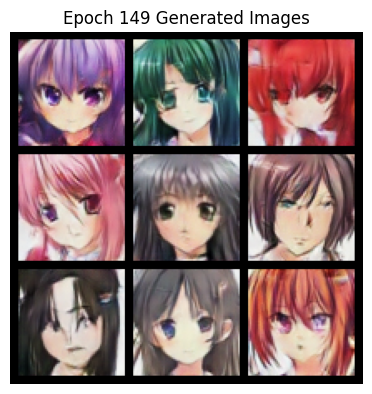

100%|██████████| 497/497 [02:05<00:00,  3.96it/s]


Discriminator Loss EPOCH 150: 0.0283
Generator Loss EPOCH 150: 6.1068
Models saved: generator_epoch_150.pth, discriminator_epoch_150.pth
Checkpoint saved at epoch 150


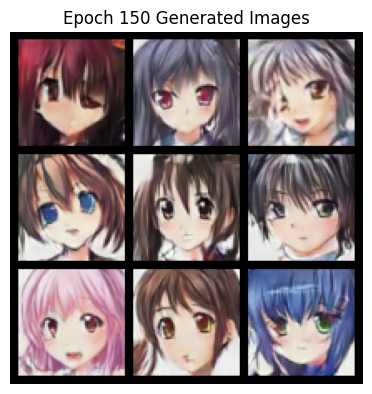

100%|██████████| 30/30 [59:51<00:00, 119.73s/it]

Training Time: 3591.97s


In [13]:
criterion = nn.BCELoss()

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=disc_LR, betas=(BETA1, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))

# Load checkpoint if available
start_epoch = load_checkpoint(generator, discriminator, generator_optimizer, discriminator_optimizer)

generator.train()
discriminator.train()

start = timeit.default_timer()
for epoch in tqdm(range(start_epoch, EPOCHS), position=0, leave=True):
#for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    generator_running_loss = 0
    discriminator_running_loss = 0
    for idx, data in enumerate(tqdm(dataloader, position=0, leave=True)):
        img_data = data[0].to(device) #size [1024, 3, 64, 64]
        dummy_labels = data[1] #size [1024]

        real_labels = torch.full((dummy_labels.size()), 1., dtype=torch.float).to(device) #size [1024]
        fake_labels = torch.full((dummy_labels.size()), 0., dtype=torch.float).to(device)

        noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device) #size [1024, 100, 1, 1]


        discriminator_real_out = discriminator(img_data).view(-1) #size [1024] .view(-1) to rid unnecessary dimensions
        discriminator_real_loss = criterion(discriminator_real_out, real_labels)
        discriminator.zero_grad()
        discriminator_real_loss.backward()

        generator_fake_out = generator(noise) #size [1024, 3, 64, 64]
        discriminator_fake_out = discriminator(generator_fake_out.detach()).view(-1) #detach used because we'll calculate it for a second time
        discriminator_fake_loss = criterion(discriminator_fake_out, fake_labels)
        discriminator_fake_loss.backward()
        discriminator_running_loss += discriminator_real_loss.item() + discriminator_fake_loss.item()
        discriminator_optimizer.step()

        discriminator_fake_out = discriminator(generator_fake_out).view(-1) #calculated it for a second time. So that we won't have to backward graphs a second time
        generator_loss = criterion(discriminator_fake_out, real_labels)
        generator_running_loss += generator_loss.item()
        generator.zero_grad()
        generator_loss.backward()
        generator_optimizer.step()


    # discriminator_loss = discriminator_running_loss / 2*(idx + 1)
    discriminator_loss = discriminator_running_loss / (2 * (idx + 1))

    generator_loss = generator_running_loss / (idx + 1)

    print(f"Discriminator Loss EPOCH {epoch+1}: {discriminator_loss:.4f}")
    print(f"Generator Loss EPOCH {epoch+1}: {generator_loss:.4f}")

    #  # Save Models After Each Epoch
    torch.save(generator.state_dict(), f"generator_epoch_{epoch+1}.pth")
    # torch.save(discriminator.state_dict(), f"discriminator_epoch_{epoch+1}.pth")

    print(f"Models saved: generator_epoch_{epoch+1}.pth, discriminator_epoch_{epoch+1}.pth")

    save_checkpoint(epoch, generator, discriminator, generator_optimizer, discriminator_optimizer)

    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[:9], padding=5, normalize=True, nrow=3).cpu(),(1,2,0)))
    plt.show()

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

In [14]:
torch.cuda.empty_cache()

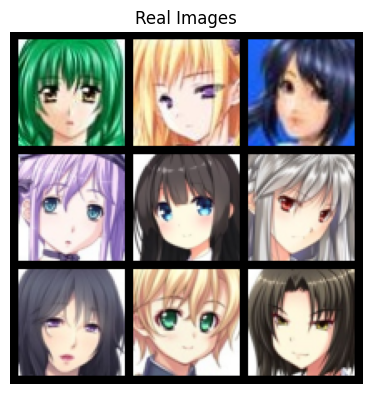

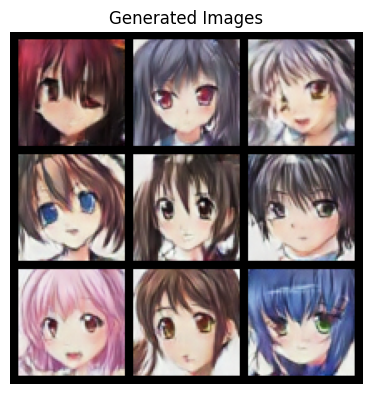

In [15]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:9], padding=5, normalize=True, nrow=3).cpu(),(1,2,0)))

plt.figure(figsize=(10,10))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[:9], padding=5, normalize=True, nrow=3).cpu(),(1,2,0)))
plt.show()

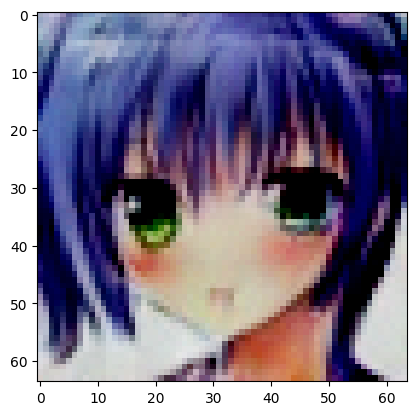

In [16]:
noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device)
generator_fake_out = generator(noise)

plt.imshow(generator_fake_out[5].detach().cpu().permute(1, 2, 0))